In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from habana_frameworks.tensorflow import load_habana_module

load_habana_module()

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


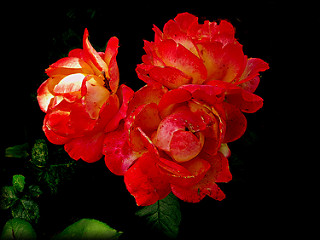

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

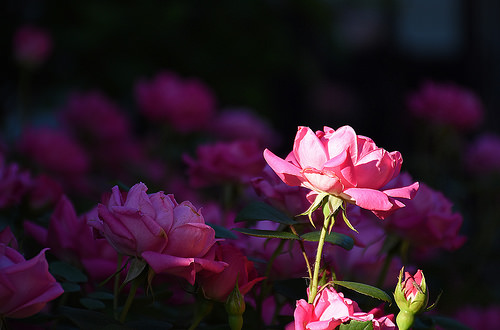

In [6]:
PIL.Image.open(str(roses[1]))

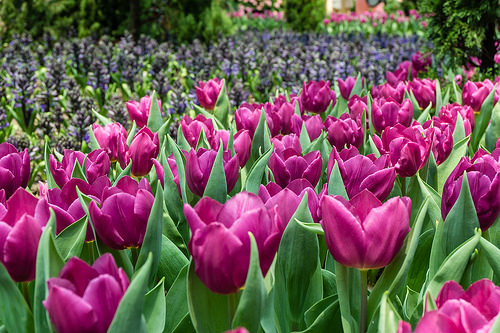

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

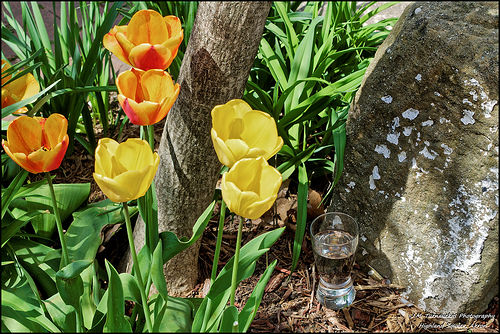

In [8]:
PIL.Image.open(str(tulips[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-02-27 18:54:35.205084: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 18:54:36.655482: W /home/jenkins/workspace/cdsoftwarebuilder/create-tensorflow-module---bpt-d/tensorflow-training/habana_device/habana_device.cpp:182] HPU initialization done for library version 1.2.0_c6aea18b_tf2.7.0


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


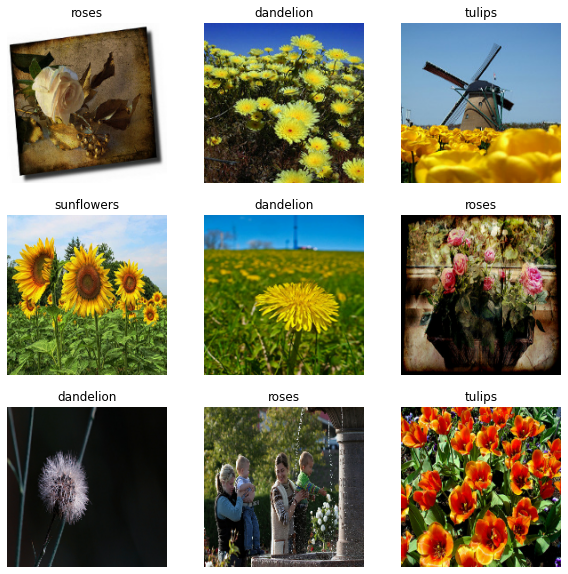

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9810147


In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 8s 31ms/step - loss: 1.4699 - accuracy: 0.3522 - val_loss: 1.3610 - val_accuracy: 0.4605
Epoch 2/10
92/92 [==============================] - 1s 11ms/step - loss: 1.3276 - accuracy: 0.4533 - val_loss: 1.3943 - val_accuracy: 0.3583
Epoch 3/10
92/92 [==============================] - 1s 11ms/step - loss: 1.3574 - accuracy: 0.4005 - val_loss: 1.3703 - val_accuracy: 0.4114
Epoch 4/10
92/92 [==============================] - 1s 11ms/step - loss: 1.3287 - accuracy: 0.4295 - val_loss: 1.4123 - val_accuracy: 0.3869
Epoch 5/10
92/92 [==============================] - 1s 11ms/step - loss: 1.3206 - accuracy: 0.4244 - val_loss: 1.3059 - val_accuracy: 0.4114
Epoch 6/10
92/92 [==============================] - 1s 11ms/step - loss: 1.2283 - accuracy: 0.4574 - val_loss: 1.2797 - val_accuracy: 0.4196
Epoch 7/10
92/92 [==============================] - 1s 11ms/step - loss: 1.1855 - accuracy: 0.4782 - val_loss: 1.1891 - val_accuracy: 0.4891
Epoch 8/10
92

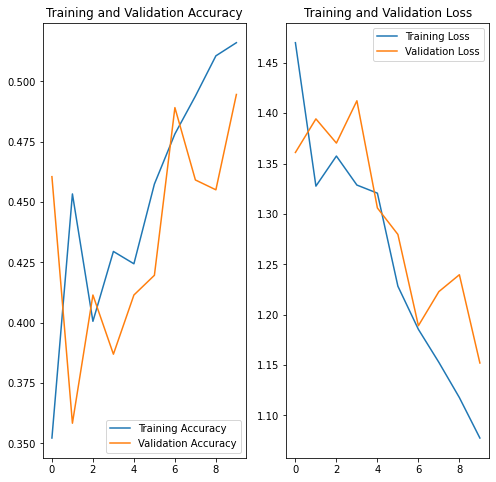

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

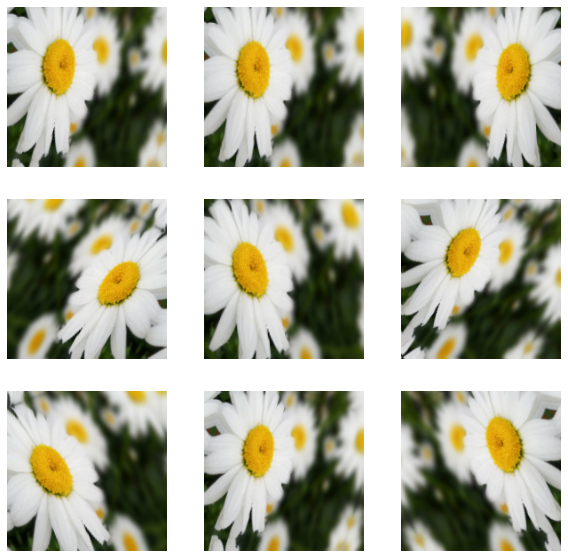

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
43/92 [=============>................] - ETA: 1s - loss: 1.4554 - accuracy: 0.3416

2022-02-27 19:01:48.259376: E /home/jenkins/workspace/cdsoftwarebuilder/create-tensorflow-module---bpt-d/tensorflow-training/synapse_helpers/graph.cpp:171] Node: sequential_2/sequential_1/random_flip/stateless_random_flip_left_right/ReverseV2/reverse_f32_n1418,type: reverse_f32 add failed. Err: 1
2022-02-27 19:01:48.260290: E /home/jenkins/workspace/cdsoftwarebuilder/create-tensorflow-module---bpt-d/tensorflow-training/synapse_helpers/graph.cpp:171] Node: sequential_2/sequential_1/random_flip/stateless_random_flip_left_right/ReverseV2/reverse_f32_n1420,type: reverse_f32 add failed. Err: 1
2022-02-27 19:01:48.260953: E /home/jenkins/workspace/cdsoftwarebuilder/create-tensorflow-module---bpt-d/tensorflow-training/synapse_helpers/graph.cpp:171] Node: sequential_2/sequential_1/random_flip/stateless_random_flip_left_right/ReverseV2/reverse_f32_n1422,type: reverse_f32 add failed. Err: 1
2022-02-27 19:01:48.261598: E /home/jenkins/workspace/cdsoftwarebuilder/create-tensorflow-module---bpt-d/t

46/92 [==============>...............] - ETA: 3s - loss: 1.4491 - accuracy: 0.3518

2022-02-27 19:01:50.241135: W /home/jenkins/workspace/cdsoftwarebuilder/create-tensorflow-module---bpt-d/tensorflow-training/habana_device/cpu_runtime_fallback/cgraph.cpp:235] Computation on HPU failed: cluster name=habana_cluster_11_121 id=2 depth=1 error: INVALID_ARGUMENT: NodeDef expected inputs 'float, int32' do not match 0 inputs specified; Op<name=Sum; signature=input:T, reduction_indices:Tidx -> output:T; attr=keep_dims:bool,default=false; attr=T:type,allowed=[DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, DT_INT8, DT_COMPLEX64, DT_INT64, DT_QINT8, DT_QUINT8, DT_QINT32, DT_BFLOAT16, DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]; attr=Tidx:type,default=DT_INT32,allowed=[DT_INT32, DT_INT64]>; NodeDef: {{node sparse_categorical_crossentropy/weighted_loss/Sum}} Cannot instantiate HabanaKernel op=Sum name=sparse_categorical_crossentropy/weighted_loss/Sum from OP_REQUIRES failed at cluster_builder_halo.cpp:1655
2022-02-27 19:01:50.244242: W /home/jenkins/workspace/cdsof

92/92 [==============================] - 11s 97ms/step - loss: 1.3472 - accuracy: 0.4036 - val_loss: 1.1598 - val_accuracy: 0.5395
Epoch 2/15
92/92 [==============================] - 11s 120ms/step - loss: 1.1323 - accuracy: 0.5276 - val_loss: 1.0446 - val_accuracy: 0.5981
Epoch 3/15
92/92 [==============================] - 11s 125ms/step - loss: 1.0405 - accuracy: 0.5971 - val_loss: 1.0246 - val_accuracy: 0.5940
Epoch 4/15
92/92 [==============================] - 11s 121ms/step - loss: 0.9739 - accuracy: 0.6277 - val_loss: 0.9829 - val_accuracy: 0.5954
Epoch 5/15
92/92 [==============================] - 11s 120ms/step - loss: 0.9192 - accuracy: 0.6434 - val_loss: 0.9538 - val_accuracy: 0.6335
Epoch 6/15
92/92 [==============================] - 11s 118ms/step - loss: 0.8861 - accuracy: 0.6529 - val_loss: 0.9332 - val_accuracy: 0.6444
Epoch 7/15
92/92 [==============================] - 11s 118ms/step - loss: 0.8832 - accuracy: 0.6557 - val_loss: 0.8814 - val_accuracy: 0.6621
Epoch 8/15


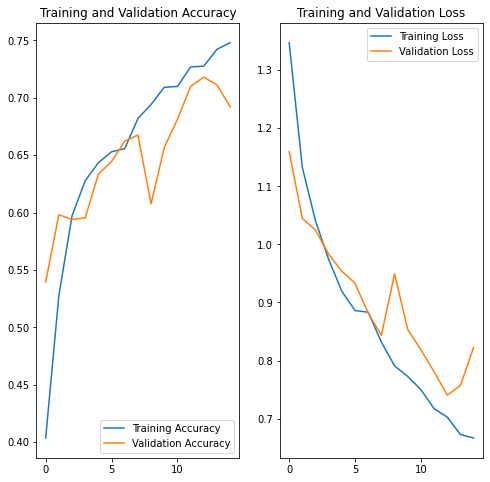

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 56.66 percent confidence.
